In [1]:
# -----------------------------------------------------------
#  FooCN_Depression – PHQ regression workflow
#  Author: <your name>
# -----------------------------------------------------------
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")  # clean up notebook output

# 1. ------------------------------------------------------------------
# Load data
# ---------
FILE = r"C:\Users\user\Documents\AI + DM Class 2025\Django\fooq2\FooCN_Depression.xlsx"
df   = pd.read_excel(FILE)

In [2]:
# 2. ------------------------------------------------------------------
# Define DV and IVs
# -----------------
y_col   = 'DV_PHQ9totalscore'          # rename if your column header differs
x_cols  = ['Qi-stagnation', 'Blood-stasis', 'Qi-deficiency', 'Yang-deficiency', 'Yin-deficiency',
           'Phlegm-dampness', 'Damp-heat', 'Inherited special', 'Balanced',
           'Dysfunctional attitude', 'Stress', 'Anxiety',
           'Perceived Stress', 'Self-esteem']

df = df.dropna(subset=[y_col] + x_cols)        # simple missing-data handling
X, y = df[x_cols], df[y_col]

In [3]:
# 3. ------------------------------------------------------------------
# Train / test split
# ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42)

In [4]:
# 4. ------------------------------------------------------------------
# Helper to report CV RMSE
def cv_rmse(model, X, y, folds=10):
    rmse_scores = np.sqrt(-cross_val_score(model, X, y,
                                           cv=KFold(folds, shuffle=True, random_state=42),
                                           scoring='neg_mean_squared_error'))
    return rmse_scores.mean()

In [5]:
# 5. ------------------------------------------------------------------
# 5.1 Linear Regression (with scaling)
lin_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('linreg', LinearRegression())
])
lin_pipe.fit(X_train, y_train)

# 5.2 Ridge & Lasso with built-in CV
alphas = np.logspace(-3, 3, 100)
ridge   = Pipeline([('scale', StandardScaler()),
                    ('ridge', RidgeCV(alphas=alphas, cv=10))]).fit(X_train, y_train)
lasso   = Pipeline([('scale', StandardScaler()),
                    ('lasso', LassoCV(alphas=None, cv=10, max_iter=10000,
                                      random_state=42))]).fit(X_train, y_train)

In [6]:
# 5.3 Random-Forest Regressor
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# 6. ------------------------------------------------------------------
# Evaluation
# ----------
models = {
    'Linear' : lin_pipe,
    'Ridge'  : ridge,
    'Lasso'  : lasso,
    'RF'     : rf
}

print("\nCross-validated RMSE (10-fold):")
for name, mdl in models.items():
    print(f"  {name:7s}: {cv_rmse(mdl, X, y):.3f}")

# Choose the model you prefer for diagnostic plots
best = lin_pipe            # change to ridge, lasso, or rf if desired

y_pred = best.predict(X_test)
print(f"\nHold-out performance (test set, n={len(y_test)}):")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"  R²  : {r2_score(y_test, y_pred):.3f}")



Cross-validated RMSE (10-fold):
  Linear : 3.571
  Ridge  : 3.163
  Lasso  : 3.242
  RF     : 3.414

Hold-out performance (test set, n=28):
  RMSE: 3.397
  R²  : 0.641


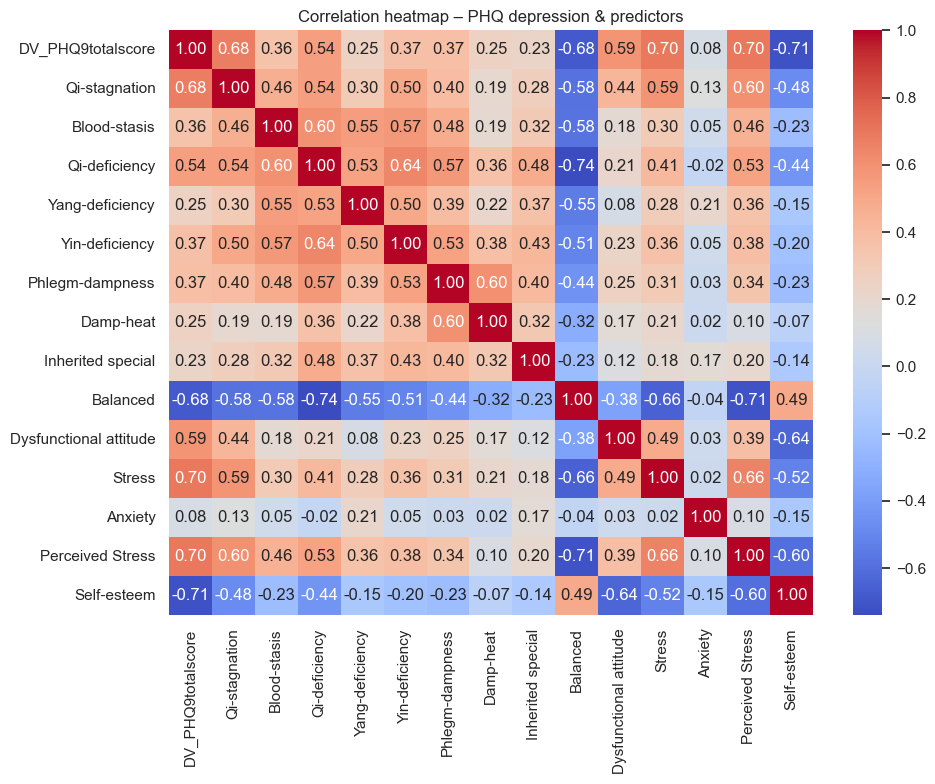

In [7]:
# 7. ------------------------------------------------------------------
# Visualisations
# --------------
sns.set(style="whitegrid", font_scale=1.0)

# 7.1 Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[[y_col] + x_cols].corr(),
            cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation heatmap – PHQ depression & predictors")
plt.tight_layout(); plt.show()

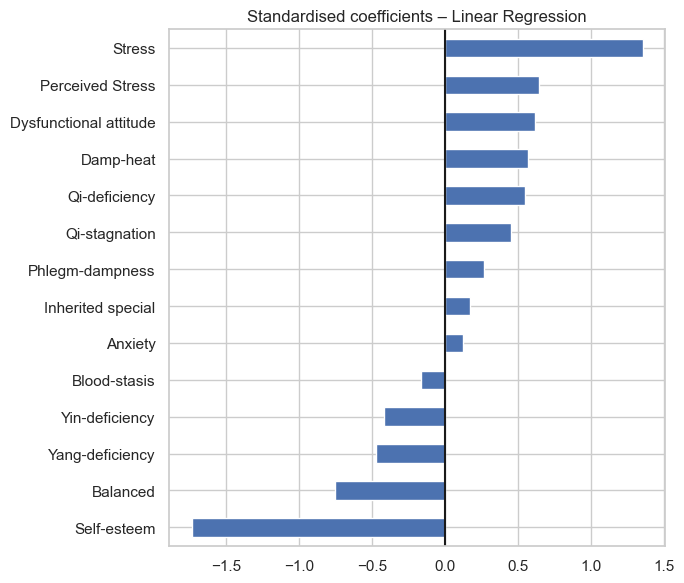

In [8]:
# 7.2 Coefficient bar chart (standardised Linear model)
coefs = pd.Series(best.named_steps['linreg'].coef_, index=x_cols)
plt.figure(figsize=(7,6))
coefs.sort_values().plot(kind='barh')
plt.title("Standardised coefficients – Linear Regression")
plt.axvline(0, color='k'); plt.tight_layout(); plt.show()

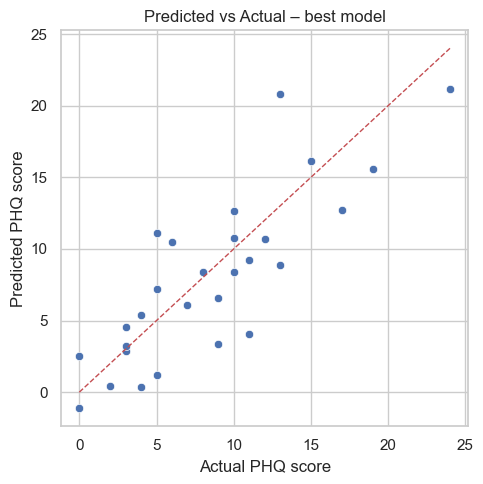

In [9]:
# 7.3 Predicted vs Actual
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=1)
plt.xlabel("Actual PHQ score"); plt.ylabel("Predicted PHQ score")
plt.title("Predicted vs Actual – best model"); plt.tight_layout(); plt.show()


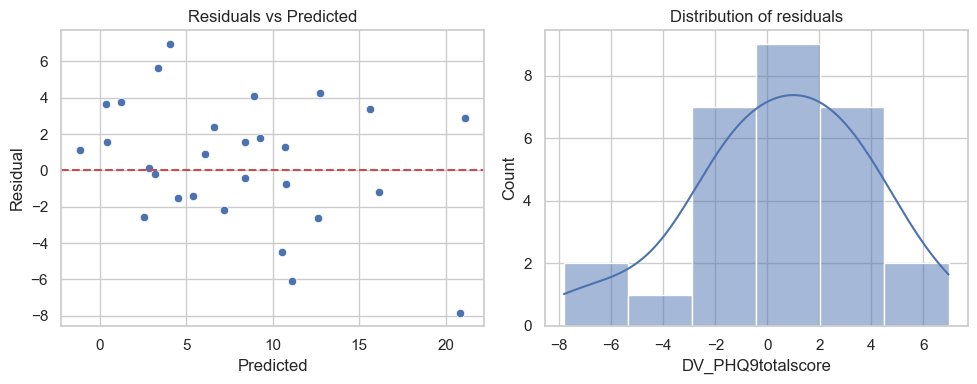

In [10]:
# 7.4 Residual plots
resid = y_test - y_pred
fig, ax = plt.subplots(1,2, figsize=(10,4))

sns.scatterplot(x=y_pred, y=resid, ax=ax[0])
ax[0].axhline(0, ls='--', c='r')
ax[0].set(xlabel="Predicted", ylabel="Residual",
          title="Residuals vs Predicted")

sns.histplot(resid, kde=True, ax=ax[1])
ax[1].set(title="Distribution of residuals")

plt.tight_layout(); plt.show()

In [11]:
import pickle

# Save model to file
with open('lin_pipe.pkl', 'wb') as f:
    pickle.dump(lin_pipe, f)

# To load:
# with open('ridge_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)